In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

# Elite checkpoint selection (used by both DRL and ES)
TRACK_ELITE = True
ELITE_METRIC = "val"  # "train" or "val"



## data split for training, val, test

In [3]:
DATA_DIR = Path("data")  # adjust if needed

prices_adj = pd.read_csv(DATA_DIR / "etf_prices_adj.csv",
                         index_col=0, parse_dates=True)
log_ret = pd.read_csv(DATA_DIR / "etf_returns_log.csv",
                      index_col=0, parse_dates=True)
simple_ret = pd.read_csv(DATA_DIR / "etf_returns_simple.csv",
                         index_col=0, parse_dates=True)

prices_adj = prices_adj.sort_index()
log_ret = log_ret.sort_index()
log_ret = log_ret.reindex(prices_adj.index).ffill().dropna(how="all")

simple_ret = simple_ret.sort_index()
simple_ret = simple_ret.reindex(prices_adj.index).ffill().dropna(how="all")


In [4]:
# ----- define train/test split (approx 70/30) -----
TRAIN_FRAC = 0.7
split_idx = int(len(log_ret) * TRAIN_FRAC)

train_ret = log_ret.iloc[:split_idx]
test_ret  = log_ret.iloc[split_idx:]

simple_ret_train = simple_ret.loc[train_ret.index]
simple_ret_test  = simple_ret.loc[test_ret.index]

train_prices = prices_adj.loc[train_ret.index]
test_prices  = prices_adj.loc[test_ret.index]

print("Train period:", train_ret.index[0], "->", train_ret.index[-1])
print("Train size: ", train_prices.shape, train_ret.shape )
print("Test period: ", test_ret.index[0], "->", test_ret.index[-1])
print("Test size: ", test_prices.shape, test_ret.shape )


Train period: 2006-02-07 00:00:00 -> 2019-12-11 00:00:00
Train size:  (3612, 8) (3612, 8)
Test period:  2019-12-12 00:00:00 -> 2025-11-18 00:00:00
Test size:  (1549, 8) (1549, 8)


In [5]:
mu = train_ret.mean()
sigma = train_ret.std().replace(0, np.nan)

def normalize_returns(df):
    return (df - mu) / sigma

train_ret_norm = normalize_returns(train_ret)
test_ret_norm  = normalize_returns(test_ret)
log_ret_norm   = normalize_returns(log_ret) 


## Calculation of rolling mean for window = 15 days

In [6]:
WINDOW = 15

roll_mean_train = train_ret_norm.rolling(WINDOW).mean()
roll_std_train  = train_ret_norm.rolling(WINDOW).std()

roll_mean_test = test_ret_norm.rolling(WINDOW).mean()
roll_std_test  = test_ret_norm.rolling(WINDOW).std()

In [7]:
log_ret_train_norm_cut = train_ret_norm.iloc[WINDOW-1:]
roll_mean_train_cut    = roll_mean_train.iloc[WINDOW-1:]
roll_std_train_cut     = roll_std_train.iloc[WINDOW-1:]
simple_ret_train_cut   = simple_ret_train.iloc[WINDOW-1:]

log_ret_test_norm_cut = test_ret_norm.iloc[WINDOW-1:]
roll_mean_test_cut    = roll_mean_test.iloc[WINDOW-1:]
roll_std_test_cut     = roll_std_test.iloc[WINDOW-1:]
simple_ret_test_cut   = simple_ret_test.iloc[WINDOW-1:]

In [30]:
print("Train cut length:", len(log_ret_train_norm_cut))
print("Test cut length:", len(log_ret_test_norm_cut))
log_ret_train_norm_cut

Train cut length: 3598
Test cut length: 1535


,US_REITs_VNQ,US_SmallCap_IWM,Gold_GLD,US_LargeCap_SPY,Europe_VGK,DevExUS_EFA,US_Bonds_AGG,Emerging_EEM
Date,,,,,,,,
2006-02-27,-0.005919,0.167181,-0.682227,0.004893,0.096519,0.243110,-0.767272,0.478440
2006-02-28,-0.203338,-0.925754,1.310176,-0.846575,-0.570190,-0.679125,0.660012,-1.419736
2006-03-01,0.286085,1.212324,0.025011,0.730568,0.596929,0.728040,-0.043785,1.452242
2006-03-02,-0.076771,-0.305965,0.967367,-0.034826,0.096264,-0.147772,-0.905958,0.035053
2006-03-03,-0.298139,-0.363161,-0.731322,-0.426736,0.190531,-0.309462,-0.737326,-0.906937
...,...,...,...,...,...,...,...,...
2019-12-05,0.014111,0.049083,0.028572,0.125819,0.001513,-0.147996,-0.446096,0.230083
2019-12-06,0.091971,0.774467,-0.891519,0.751250,0.520449,0.645987,-0.537342,0.303626
2019-12-09,0.086196,-0.149019,-0.046962,-0.298133,-0.304700,-0.390125,0.127795,-0.219607


## DRL first attempt of optimization (train/test split)

In [31]:
# --- Build base features: [last_ret_norm, mean, std] ---
def build_feat_base(last_ret_df, mean_df, std_df) -> np.ndarray:
    # All [T, N_assets], same index/order
    last_ret = last_ret_df.values
    mean_v   = mean_df.values
    std_v    = std_df.values
    return np.concatenate([last_ret, mean_v, std_v], axis=1)  # [T, 3*N_assets]

feat_base_train_np = build_feat_base(
    log_ret_train_norm_cut,
    roll_mean_train_cut,
    roll_std_train_cut,
)
feat_base_test_np = build_feat_base(
    log_ret_test_norm_cut,
    roll_mean_test_cut,
    roll_std_test_cut,
)

asset_simple_train_np = simple_ret_train_cut.values  # [T_train, N_assets]
asset_simple_test_np  = simple_ret_test_cut.values  # [T_test, N_assets]

N_assets = asset_simple_train_np.shape[1]
F = feat_base_train_np.shape[1]
print("N_assets:", N_assets, "Feature dim:", F)

# --- Convert to JAX arrays ---
feat_base_train = jnp.array(feat_base_train_np, dtype=jnp.float32)
feat_base_test  = jnp.array(feat_base_test_np, dtype=jnp.float32)

asset_simple_train = jnp.array(asset_simple_train_np, dtype=jnp.float32)
asset_simple_test  = jnp.array(asset_simple_test_np, dtype=jnp.float32)


N_assets: 8 Feature dim: 24


In [8]:
WINDOW = 15
N_assets = log_ret_train_norm_cut.shape[1]

def make_dataset_with_window(
    log_ret_norm_df: pd.DataFrame,
    simple_ret_df: pd.DataFrame,
    window: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Build (feat_base, asset_simple) for one split.

    feat_t = [flatten(last window of normalized log returns), rolling mean_t, rolling std_t]

    Returns
    -------
    feat_base : np.ndarray  [T_eff, F]
    asset_simple : np.ndarray [T_eff, N_assets]
    """
    # rolling on normalized returns
    roll_mean = log_ret_norm_df.rolling(window).mean()
    roll_std  = log_ret_norm_df.rolling(window).std()

    ret_norm = log_ret_norm_df.values           # [T, N_assets]
    mean_v   = roll_mean.values                 # [T, N_assets]
    std_v    = roll_std.values                  # [T, N_assets]
    simple_v = simple_ret_df.values             # [T, N_assets]

    T, N = ret_norm.shape
    feats = []
    simple_out = []

    # start at index window-1 so window is full
    for i in range(window-1, T):
        window_slice = ret_norm[i - window + 1 : i + 1, :]   # [window, N]
        window_flat = window_slice.reshape(-1)               # [window * N]
        feat_t = np.concatenate([window_flat, mean_v[i], std_v[i]], axis=0)
        feats.append(feat_t)
        simple_out.append(simple_v[i])

    feat_base = np.stack(feats, axis=0)          # [T_eff, window*N + 2N]
    asset_simple = np.stack(simple_out, axis=0)  # [T_eff, N]
    return feat_base, asset_simple

# Train
feat_base_train_np, asset_simple_train_np = make_dataset_with_window(
    train_ret_norm,
    simple_ret_train,
    WINDOW,
)

# Test
feat_base_test_np, asset_simple_test_np = make_dataset_with_window(
    test_ret_norm,
    simple_ret_test,
    WINDOW,
)

print("feat_base_train_np shape:", feat_base_train_np.shape)
print("asset_simple_train_np shape:", asset_simple_train_np.shape)
print("feat_base_test_np shape:", feat_base_test_np.shape)
print("asset_simple_test_np shape:", asset_simple_test_np.shape)

N_assets = asset_simple_train_np.shape[1]
F = feat_base_train_np.shape[1]   # this will now be WINDOW * N_assets + 2 * N_assets
print(F)
feat_base_train = jnp.array(feat_base_train_np, dtype=jnp.float32)
feat_base_test  = jnp.array(feat_base_test_np, dtype=jnp.float32)

asset_simple_train = jnp.array(asset_simple_train_np, dtype=jnp.float32)
asset_simple_test  = jnp.array(asset_simple_test_np, dtype=jnp.float32)



feat_base_train_np shape: (3598, 136)
asset_simple_train_np shape: (3598, 8)
feat_base_test_np shape: (1535, 136)
asset_simple_test_np shape: (1535, 8)
136


In [9]:
rets = simple_ret_train  # DataFrame with SPY, AGG, GLD, ...

ann_factor = 252

for col in rets.columns:
    r = rets[col].values
    mu = r.mean() * ann_factor
    sigma = r.std() * jnp.sqrt(ann_factor)
    sharpe = mu / (sigma + 1e-8)
    print(col, mu, sigma, sharpe)
asset_labels = list(log_ret.columns)        # e.g. ["US_LargeCap_SPY", "Gold_GLD", ..., "US_Bonds_AGG", ...]
asset_labels_full = asset_labels + ["Cash"] # used elsewhere
N_assets = len(asset_labels)
num_weights = N_assets + 1                  # +1 for cash

prior_w = jnp.zeros((num_weights,), dtype=jnp.float32)

idx_spy = asset_labels.index("US_LargeCap_SPY")   # or whatever your SPY column label is
idx_agg = asset_labels.index("US_Bonds_AGG")      # your AGG label

prior_w = prior_w.at[idx_spy].set(1)
prior_w = prior_w.at[idx_agg].set(0)

print(prior_w)

US_REITs_VNQ 0.11441799139534886 0.30723405 0.37241313
US_SmallCap_IWM 0.09646613651162789 0.23189269 0.4159947
Gold_GLD 0.07906191069767443 0.18184502 0.43477628
US_LargeCap_SPY 0.10004113534883718 0.1851806 0.54023546
Europe_VGK 0.06732972418604649 0.23743273 0.2835739
DevExUS_EFA 0.05880678069767443 0.21936926 0.2680721
US_Bonds_AGG 0.0407878876744186 0.046426155 0.87855387
Emerging_EEM 0.08144101046511629 0.29775387 0.27351788
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [10]:
from v1_DRL import TrainConfig, train_drl
from v1_MLP import MLP
# Total input dim for the MLP:
#  - feat_base has dim F
#  - rollout_episode concatenates prev weights of size (N_assets + 1)
state_dim = F + (N_assets + 1)
hidden_dim = 64
output_dim = N_assets + 1  # 8 assets + cash

key = random.PRNGKey(0)
mlp_init = MLP.init(key, state_dim, hidden_dim, output_dim)

cfg = TrainConfig(
    num_iters=201,
    lr=0.0075,
    cost_rate=0.0001,
    temperature=1,
    log_every=20,
    k_rebalance = 30,
    horizon_H = 90,
    w_sharpe=0.4,
    w_return=0.6,
    lambda_prior=0.0,
    track_elite=TRACK_ELITE,
    elite_metric=ELITE_METRIC,

)

mlp_trained, train_losses, test_losses = train_drl(
    mlp_init,
    feat_base_train,
    asset_simple_train,
    cfg,
    feat_base_test,
    asset_simple_test,
    prior_weights=prior_w
)





[DRL] iter    0 | train_loss=-0.177736 | train_score=0.177736 | val_loss=-0.299761 | val_score=0.299761


KeyboardInterrupt: 

Train total return: 0.9638815522193909
Test total return: 0.6714942455291748
weights_train shape: (3598, 9)
Total train return (sum of rewards): 0.9638815522193909
Total test return (sum of rewards):  0.6714942455291748


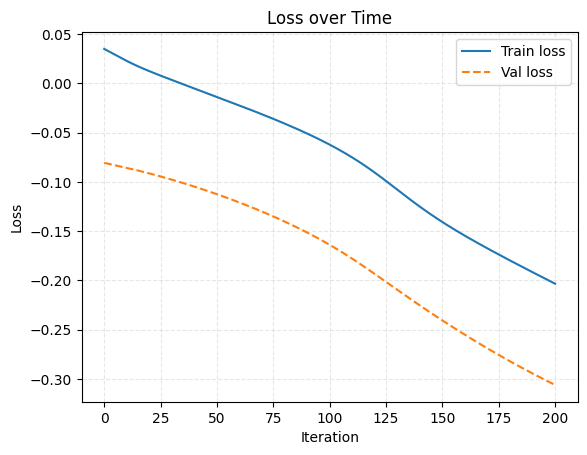

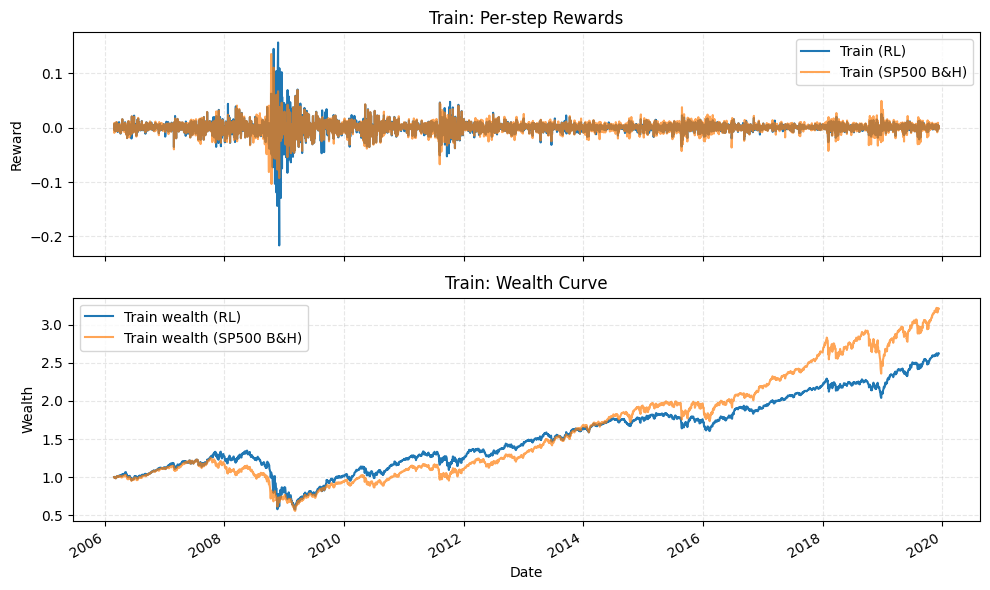

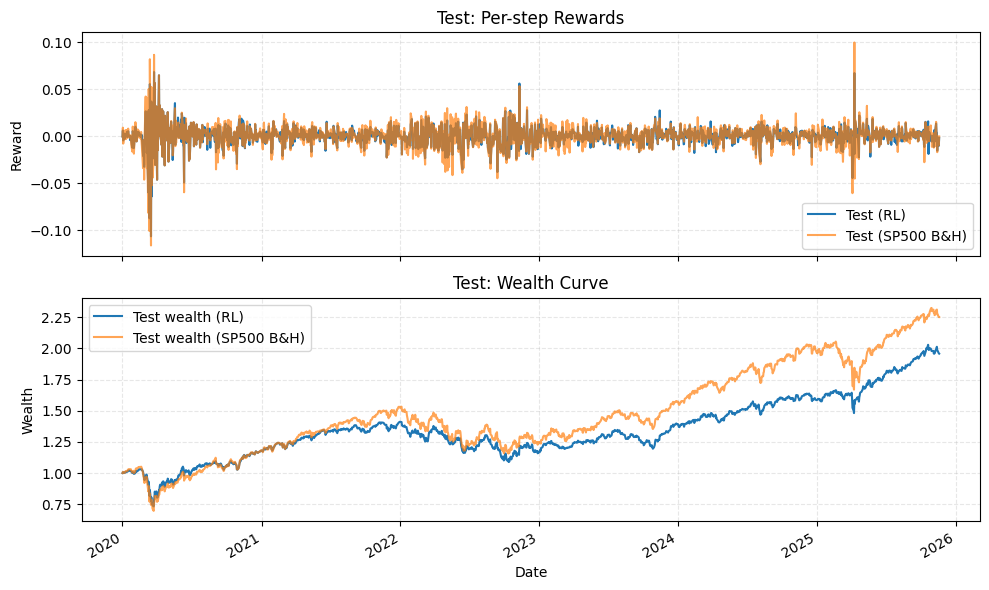

In [22]:
from visualizations import plot_loss_curve, plot_episode_performance_split, plot_allocation_over_time
from v1_DRL import evaluate_policy_with_weights

# Evaluate on train with weights
rewards_train, total_train, weights_train = evaluate_policy_with_weights(
    mlp_trained,
    feat_base_train,
    asset_simple_train,
    cost_rate=cfg.cost_rate,
    temperature=cfg.temperature,
    k_rebalance=cfg.k_rebalance,
)

# Evaluate on test with weights
rewards_test, total_test, weights_test = evaluate_policy_with_weights(
    mlp_trained,
    feat_base_test,
    asset_simple_test,
    cost_rate=cfg.cost_rate,
    temperature=cfg.temperature,
    k_rebalance=cfg.k_rebalance,
)

print("Train total return:", float(total_train))
print("Test total return:", float(total_test))
print("weights_train shape:", weights_train.shape)


print("Total train return (sum of rewards):", float(total_train))
print("Total test return (sum of rewards): ", float(total_test))

# --- SP500 / SPY baseline (buy & hold) --- strategy comparison
SPY_COL = "US_LargeCap_SPY"  

spy_train_simple = simple_ret_train_cut[SPY_COL].values
spy_test_simple  = simple_ret_test_cut[SPY_COL].values

# --- Visualizations ---
plot_loss_curve(train_losses, test_losses)


fig_train, fig_test = plot_episode_performance_split(
    rewards_train,
    rewards_test,
    baseline_simple_train=spy_train_simple,
    baseline_simple_val=spy_test_simple,
    dates_train=log_ret_train_norm_cut.index,
    dates_val=log_ret_test_norm_cut.index,
    initial_wealth=1.0,
    label_val="Test",
)


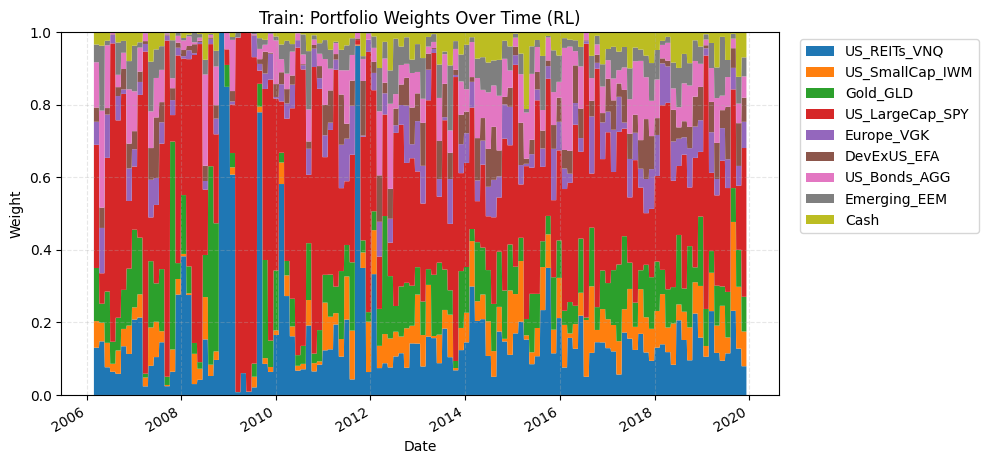

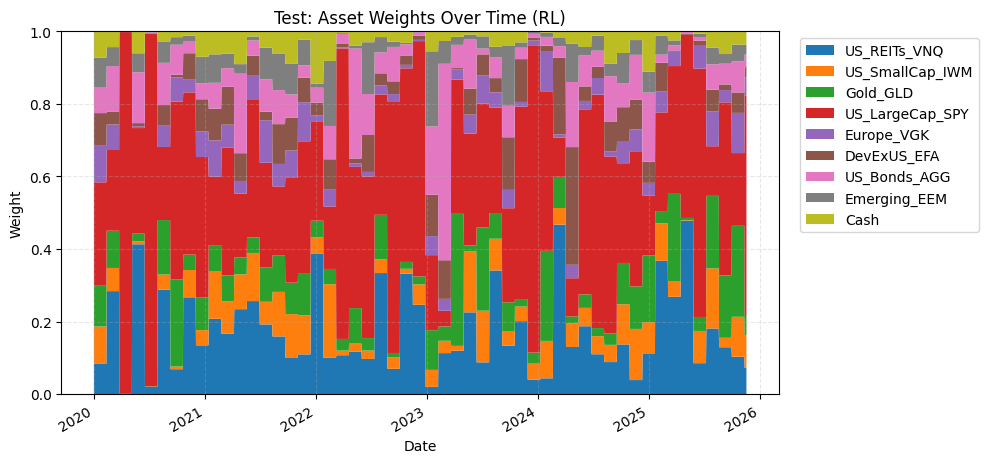

<Axes: title={'center': 'Test: Asset Weights Over Time (RL)'}, xlabel='Date', ylabel='Weight'>

In [23]:

# asset labels: 10 ETFs + Cash
asset_labels_full = list(log_ret.columns) + ["Cash"]

# plot including cash:
plot_allocation_over_time(
    np.array(weights_train),
    asset_labels=asset_labels_full,
    dates=log_ret_train_norm_cut.index,
    title="Train: Portfolio Weights Over Time (RL)",
)

# or exclude cash if you want to focus only on risky assets
asset_labels_no_cash = list(log_ret.columns)
plot_allocation_over_time(
    np.array(weights_test),
    asset_labels=asset_labels_full,
    dates=log_ret_test_norm_cut.index,
    title="Test: Asset Weights Over Time (RL)",
)



In [71]:

from v1_evolutionary_strategy import ESConfig, train_es


state_dim = F + (N_assets + 1)  # features + previous weights
hidden_dim = 64
output_dim = N_assets + 1       # 8 ETFs + cash

key = random.PRNGKey(0)
mlp_init = MLP.init(key, state_dim, hidden_dim, output_dim)

# 60/40 prior: SPY / AGG
asset_labels = list(log_ret.columns)    # whatever you use
num_weights = N_assets + 1

prior_w = jnp.zeros((num_weights,), dtype=jnp.float32)
idx_spy = asset_labels.index("US_LargeCap_SPY")
idx_agg = asset_labels.index("US_Bonds_AGG")

prior_w = prior_w.at[idx_spy].set(0.6)
prior_w = prior_w.at[idx_agg].set(0.4)
# cash left at 0.0; you can set small cash if you want

# ES hyperparams – reuse economic bits from your TrainConfig
es_cfg = ESConfig(
    num_generations=120,
    pop_size=64,
    sigma=0.2,
    lr=0.03,

    cost_rate=0.0001,       # from your TrainConfig
    temperature=1.0,
    k_rebalance=30,
    horizon_H=90,
    w_sharpe=0.4,
    w_return=0.6,
    lambda_prior=0.0,
    track_elite=TRACK_ELITE,
    elite_metric=ELITE_METRIC,
)

mlp_es, es_train_losses, es_test_losses = train_es(
    mlp_init,
    feat_base_train,
    asset_simple_train,
    es_cfg,
    feat_base_val=feat_base_test,
    asset_simple_val=asset_simple_test,
    prior_weights=prior_w,
)


[ES] gen    0 | train_loss=-0.178191 | train_score=0.178191 | val_loss=-0.299437 | val_score=0.299437


KeyboardInterrupt: 

ES Train total return: 2.452406883239746
ES Val total return:   0.40728649497032166
ES weights_train shape: (2830, 9)


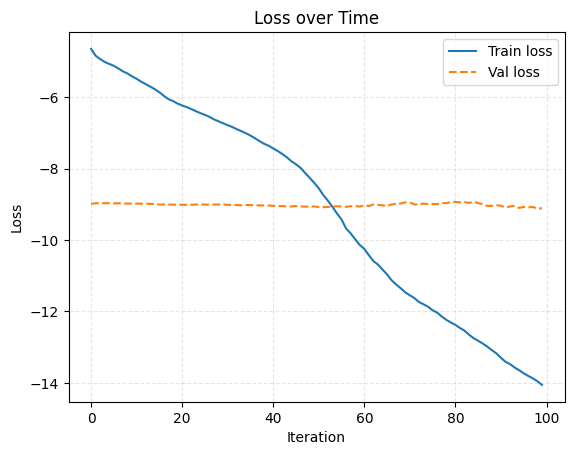

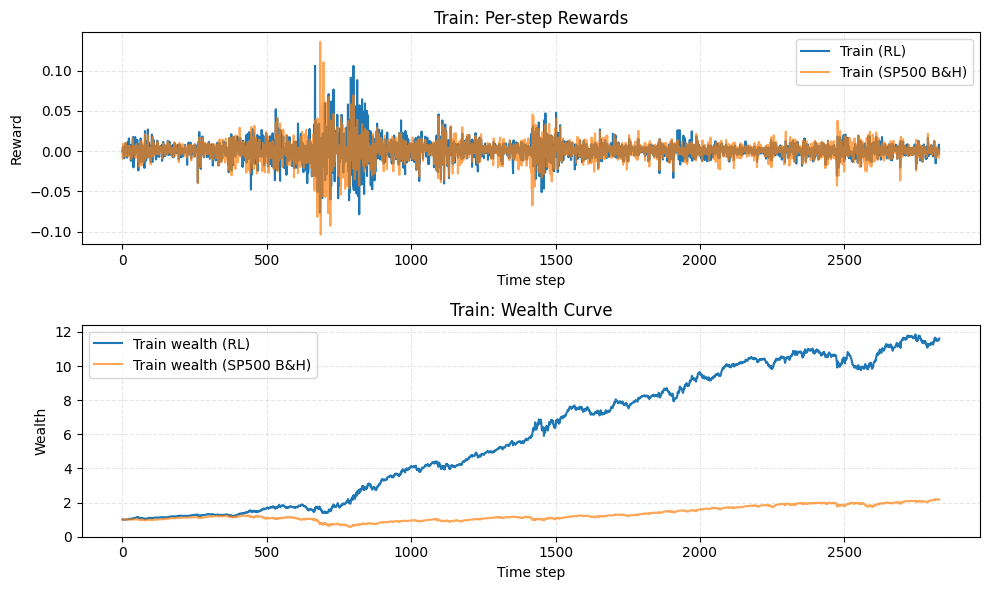

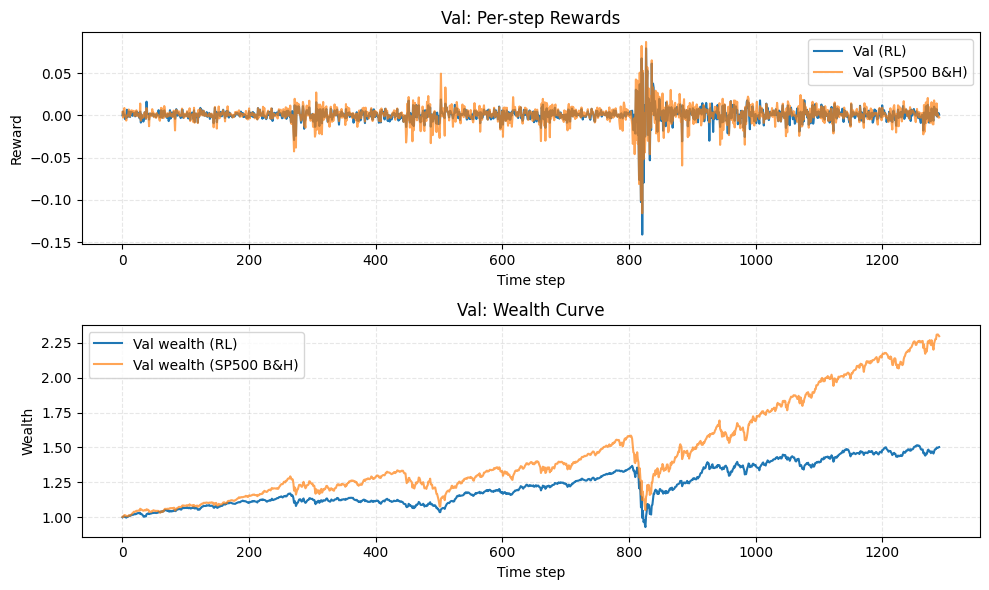

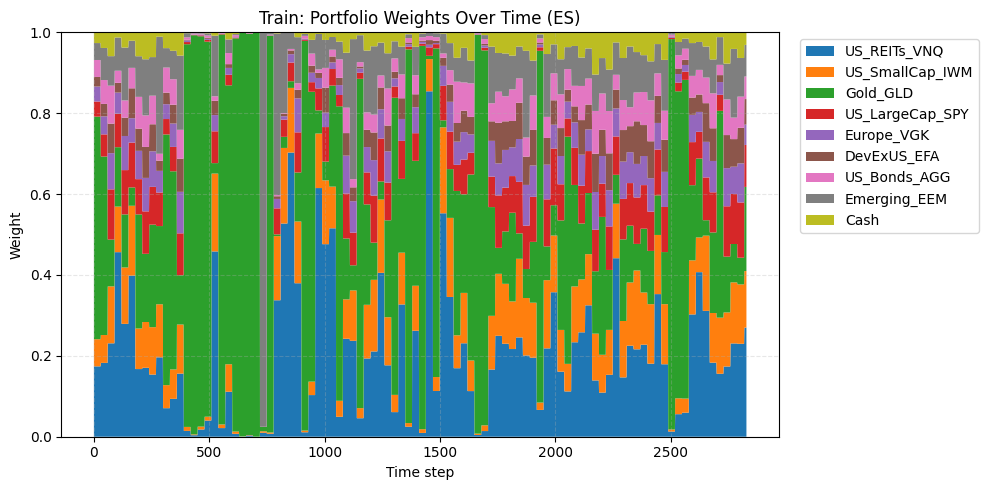

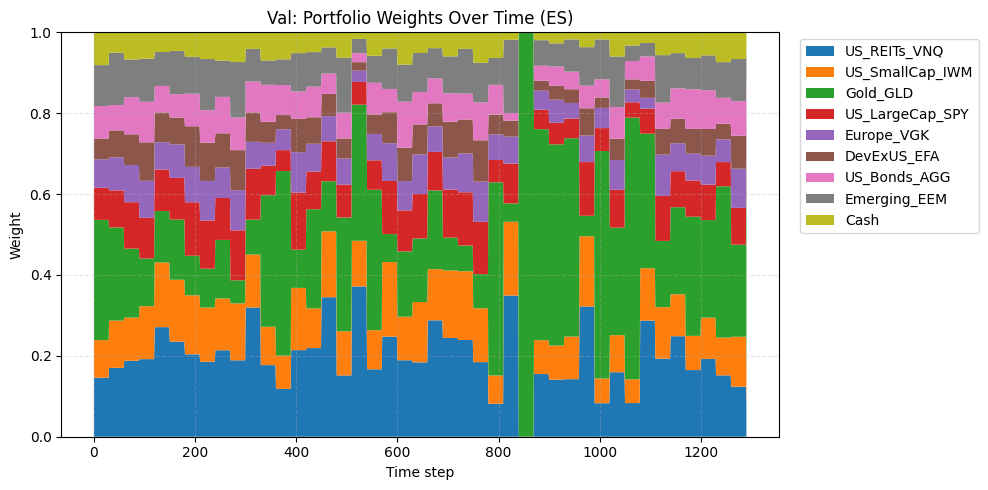

<Axes: title={'center': 'Val: Portfolio Weights Over Time (ES)'}, xlabel='Time step', ylabel='Weight'>

In [26]:
from visualizations import plot_loss_curve, plot_episode_performance_split, plot_allocation_over_time
from v1_DRL import evaluate_policy_with_weights

# --- Evaluate ES policy on train & test ---

rewards_train_es, total_train_es, weights_train_es = evaluate_policy_with_weights(
    mlp_es,
    feat_base_train,
    asset_simple_train,
    cost_rate=es_cfg.cost_rate,
    temperature=es_cfg.temperature,
    k_rebalance=es_cfg.k_rebalance,
)

rewards_test_es, total_test_es, weights_test_es = evaluate_policy_with_weights(
    mlp_es,
    feat_base_test,
    asset_simple_test,
    cost_rate=es_cfg.cost_rate,
    temperature=es_cfg.temperature,
    k_rebalance=es_cfg.k_rebalance,
)

print("ES Train total return:", float(total_train_es))
print("ES Test total return: ", float(total_test_es))
print("ES weights_train shape:", weights_train_es.shape)

# --- SP500 / SPY baseline (buy & hold), same as before ---

SPY_COL = "US_LargeCap_SPY"  # keep this consistent with your DataFrame

spy_train_simple = simple_ret_train_cut[SPY_COL].values
spy_test_simple  = simple_ret_test_cut[SPY_COL].values

# --- Loss curves for ES (mirrors your gradient plot) ---

plot_loss_curve(es_train_losses, es_test_losses)

# --- Performance vs SPY for ES policy (same as before, just *_es) ---

fig_train_es, fig_test_es = plot_episode_performance_split(
    rewards_train_es,
    rewards_test_es,
    baseline_simple_train=spy_train_simple,
    baseline_simple_val=spy_test_simple,
    dates_train=log_ret_train_norm_cut.index,
    dates_val=log_ret_test_norm_cut.index,
    initial_wealth=1.0,
    label_policy="ES",
    label_val="Test",
)

# --- Allocation over time for ES policy (train & test) ---

asset_labels_full = list(log_ret.columns) + ["Cash"]

plot_allocation_over_time(
    weights_train_es,
    asset_labels=asset_labels_full,
    dates=log_ret_train_norm_cut.index,
    title="Train: Portfolio Weights Over Time (ES)",
)

plot_allocation_over_time(
    weights_test_es,
    asset_labels=asset_labels_full,
    dates=log_ret_test_norm_cut.index,
    title="Test: Portfolio Weights Over Time (ES)",
)


## Grid Search (Hyperparameter Tuning)

Pick stable ES `(sigma, lr)` and DRL `lr` (200 iterations/generations each).


In [11]:
# Shared helpers for grid search
from v1_steps import episode_loss_mixed

SELECT_ON = "train"  # "train" (recommended) or "test" (leakage)

def objective_loss_and_score(mlp, feat_base, asset_simple, cfg, prior_w):
    loss = episode_loss_mixed(
        mlp.params,
        mlp.config,
        feat_base,
        asset_simple,
        cost_rate=cfg.cost_rate,
        temperature=cfg.temperature,
        k_rebalance=cfg.k_rebalance,
        horizon_H=cfg.horizon_H,
        w_sharpe=cfg.w_sharpe,
        w_return=cfg.w_return,
        lambda_prior=cfg.lambda_prior,
        prior_weights=prior_w,
    )
    loss_f = float(loss)
    return loss_f, -loss_f

# Recompute dims from data (so grid-search cells are self-contained)
F_ = int(feat_base_train.shape[1])
N_ = int(asset_simple_train.shape[1])
state_dim = F_ + (N_ + 1)
hidden_dim = 64
output_dim = N_ + 1


In [12]:
# === DRL: LR grid search (200 iters) ===
from dataclasses import replace

import pandas as pd

from v1_DRL import TrainConfig, train_drl
from v1_MLP import MLP

DRL_NUM_ITERS = 200
DRL_LR_GRID = [0.005, 0.01, 0.05, 0.1]

drl_cfg_base = TrainConfig(
    num_iters=DRL_NUM_ITERS,
    lr=DRL_LR_GRID[0],
    cost_rate=0.0001,
    temperature=1.0,
    log_every=0,
    eval_every=1,
    k_rebalance=30,
    horizon_H=90,
    w_sharpe=0.4,
    w_return=0.6,
    lambda_prior=0.0,
    track_elite=TRACK_ELITE,
    elite_metric=ELITE_METRIC,
)

rows = []
best_drl = None
best_score = -1e18

for lr in DRL_LR_GRID:
    mlp0 = MLP.init(random.PRNGKey(0), state_dim, hidden_dim, output_dim)
    cfg = replace(drl_cfg_base, lr=float(lr))

    mlp, train_losses, test_losses = train_drl(
        mlp0,
        feat_base_train,
        asset_simple_train,
        cfg,
        feat_base_test,
        asset_simple_test,
        prior_weights=prior_w,
    )

    train_loss, train_score = objective_loss_and_score(mlp, feat_base_train, asset_simple_train, cfg, prior_w)
    test_loss, test_score = objective_loss_and_score(mlp, feat_base_test, asset_simple_test, cfg, prior_w)

    rows.append(
        {
            "lr": float(lr),
            "train_score": train_score,
            "test_score": test_score,
            "train_loss": train_loss,
            "test_loss": test_loss,
        }
    )

    sel_score = test_score if SELECT_ON == "test" else train_score
    if sel_score > best_score:
        best_score = sel_score
        best_drl = {
            "lr": float(lr),
            "cfg": cfg,
            "mlp": mlp,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_score": train_score,
            "test_score": test_score,
        }

drl_lr_grid_df = pd.DataFrame(rows).sort_values(
    "test_score" if SELECT_ON == "test" else "train_score",
    ascending=False,
)

BEST_DRL_LR = best_drl["lr"]
print(f"[DRL grid] selected lr={BEST_DRL_LR} by {SELECT_ON}_score")
drl_lr_grid_df


[DRL] elite_val iter    1 | loss=-0.299761 | score=0.299761
[DRL] elite_val iter  199 | loss=-0.302898 | score=0.302898
[DRL] elite_val iter  199 | loss=-0.365087 | score=0.365087
[DRL] elite_val iter  124 | loss=-0.368936 | score=0.368936
[DRL grid] selected lr=0.1 by train_score


,lr,train_score,test_score,train_loss,test_loss
3,0.100,0.863275,0.368936,-0.863275,-0.368936
2,0.050,0.809460,0.365087,-0.809460,-0.365087
1,0.010,0.363561,0.302898,-0.363561,-0.302898
0,0.005,0.178879,0.299761,-0.178879,-0.299761


In [13]:
# === ES: (sigma, lr) grid search (200 gens) ===
from dataclasses import replace

import pandas as pd

from v1_evolutionary_strategy import ESConfig, train_es
from v1_MLP import MLP

ES_NUM_GENERATIONS = 200
ES_POP_SIZE = 64

# Keep this grid small; ES can get slow.
ES_SIGMA_GRID = [0.05, 0.1, 0.2, 0.5]
ES_LR_GRID = [0.05, 0.1, 0.2, 0.5]
ES_SEED = 0

es_cfg_base = ESConfig(
    num_generations=ES_NUM_GENERATIONS,
    pop_size=ES_POP_SIZE,
    sigma=ES_SIGMA_GRID[0],
    lr=ES_LR_GRID[0],
    cost_rate=0.0001,
    temperature=1.0,
    k_rebalance=30,
    horizon_H=90,
    w_sharpe=0.4,
    w_return=0.6,
    lambda_prior=0.0,
    log_every=0,
    eval_every=1,
    seed=ES_SEED,
    track_elite=TRACK_ELITE,
    elite_metric=ELITE_METRIC,
)

rows = []
best_es = None
best_score = -1e18

for sigma in ES_SIGMA_GRID:
    for lr in ES_LR_GRID:
        mlp0 = MLP.init(random.PRNGKey(0), state_dim, hidden_dim, output_dim)
        cfg = replace(es_cfg_base, sigma=float(sigma), lr=float(lr))

        mlp, train_losses, test_losses = train_es(
            mlp0,
            feat_base_train,
            asset_simple_train,
            cfg,
            feat_base_val=feat_base_test,
            asset_simple_val=asset_simple_test,
            prior_weights=prior_w,
        )

        train_loss, train_score = objective_loss_and_score(mlp, feat_base_train, asset_simple_train, cfg, prior_w)
        test_loss, test_score = objective_loss_and_score(mlp, feat_base_test, asset_simple_test, cfg, prior_w)

        rows.append(
            {
                "sigma": float(sigma),
                "lr": float(lr),
                "train_score": train_score,
                "test_score": test_score,
                "train_loss": train_loss,
                "test_loss": test_loss,
            }
        )

        sel_score = test_score if SELECT_ON == "test" else train_score
        if sel_score > best_score:
            best_score = sel_score
            best_es = {
                "sigma": float(sigma),
                "lr": float(lr),
                "cfg": cfg,
                "mlp": mlp,
                "train_losses": train_losses,
                "test_losses": test_losses,
                "train_score": train_score,
                "test_score": test_score,
            }

es_sigma_lr_grid_df = pd.DataFrame(rows).sort_values(
    "test_score" if SELECT_ON == "test" else "train_score",
    ascending=False,
)

BEST_ES_SIGMA = best_es["sigma"]
BEST_ES_LR = best_es["lr"]
print(f"[ES grid] selected (sigma, lr)=({BEST_ES_SIGMA}, {BEST_ES_LR}) by {SELECT_ON}_score")
es_sigma_lr_grid_df


[ES] elite_val gen   55 | loss=-0.395912 | score=0.395912
[ES] elite_val gen  160 | loss=-0.411809 | score=0.411809
[ES] elite_val gen   39 | loss=-0.394907 | score=0.394907
[ES] elite_val gen   54 | loss=-0.609597 | score=0.609597
[ES] elite_val gen   64 | loss=-0.357914 | score=0.357914
[ES] elite_val gen   37 | loss=-0.409290 | score=0.409290
[ES] elite_val gen   17 | loss=-0.427447 | score=0.427447
[ES] elite_val gen  172 | loss=-0.529358 | score=0.529358
[ES] elite_val gen  172 | loss=-0.331891 | score=0.331891
[ES] elite_val gen   95 | loss=-0.320196 | score=0.320196
[ES] elite_val gen   39 | loss=-0.370414 | score=0.370414
[ES] elite_val gen  195 | loss=-0.388329 | score=0.388329
[ES] elite_val gen    2 | loss=-0.300073 | score=0.300073
[ES] elite_val gen  194 | loss=-0.312105 | score=0.312105
[ES] elite_val gen  199 | loss=-0.426377 | score=0.426377
[ES] elite_val gen  174 | loss=-0.519373 | score=0.519373
[ES grid] selected (sigma, lr)=(0.05, 0.1) by train_score


,sigma,lr,train_score,test_score,train_loss,test_loss
1,0.05,0.10,1.561826,0.411809,-1.561826,-0.411809
7,0.10,0.50,1.434988,0.529358,-1.434988,-0.529358
2,0.05,0.20,1.194122,0.394907,-1.194122,-0.394907
3,0.05,0.50,0.957795,0.609597,-0.957795,-0.609597
11,0.20,0.50,0.804412,0.388329,-0.804412,-0.388329
0,0.05,0.05,0.703608,0.395912,-0.703608,-0.395912
5,0.10,0.10,0.598355,0.409290,-0.598355,-0.409290
4,0.10,0.05,0.552182,0.357914,-0.552182,-0.357914
6,0.10,0.20,0.549653,0.427447,-0.549653,-0.427447
9,0.20,0.10,0.512469,0.320196,-0.512469,-0.320196
